In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt'
feature_name_df = pd.read_csv(url, sep='\s+', header=None, names=['column index', 'column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()

In [3]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

X_train.columns = feature_name
X_test.columns = feature_name

In [4]:
y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None)
y_test = pd.read_csv(y_test_url, sep='\s+', header=None)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [6]:
from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)

    return pca.transform(ss_data), pca

In [7]:
%%time
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pca.shape

Wall time: 144 ms


(7352, 2)

In [8]:
pca.mean_.shape, pca.components_.shape

((561,), (2, 561))

In [9]:
cols = ['pca_' + str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

In [10]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_' + str(n) for n in range(pca.components_.shape[0])]
    return pd.DataFrame(pca_data, columns=cols)

In [12]:
%%time

HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()

Wall time: 129 ms


,pca_0,pca_1,action
0,-5.520280,-0.290278,5
1,-5.535350,-0.082530,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


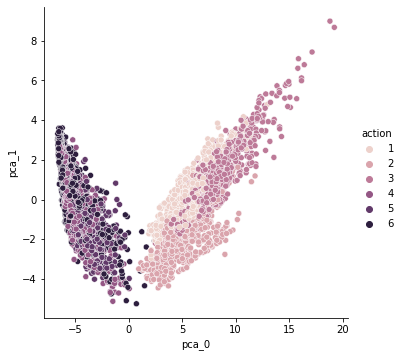

In [13]:
import seaborn as sns

sns.pairplot(HAR_pd_pca, hue='action', height=5, x_vars=['pca_0'], y_vars=['pca_1']);

In [14]:
import numpy as np

def print_variance_ratio(pca):
    print('variance ratio :', pca.explained_variance_ratio_)
    print('sum of variance ratio :', np.sum(pca.explained_variance_ratio_))

In [15]:
print_variance_ratio(pca)

variance ratio : [0.6255444  0.04913023]
sum of variance ratio : 0.6746746270487951


In [16]:
%%time

HAR_pca, pca = get_pca_data(X_train, n_components=3)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()

Wall time: 152 ms


,pca_0,pca_1,pca_2,action
0,-5.520280,-0.290278,-1.529929,5
1,-5.535350,-0.082530,-1.924804,5
2,-5.474988,0.287387,-2.144642,5
3,-5.677232,0.897031,-2.018220,5
4,-5.748749,1.162952,-2.139533,5


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': [6, 8, 10],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(HAR_pca, y_train.values.reshape(-1,))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [18]:
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
cv_result_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [19]:
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']

In [20]:
cv_result_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
1,1,0.751224,100,6
4,1,0.751224,100,6
19,3,0.751088,100,8
22,3,0.751088,100,8
2,5,0.750000,200,6


In [21]:
 from sklearn.metrics import accuracy_score

 rf_clf_best = grid_cv.best_estimator_
 rf_clf_best.fit(HAR_pca, y_train.values.reshape(-1,))

 pred1 = rf_clf_best.predict(pca.transform(X_test))

 accuracy_score(y_test, pred1)

0.7573803868340685